# Лабораторна робота #1

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

generator = torch.Generator().manual_seed(5921)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),  # convert to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # img = (img - mean / std)
])

dataset = datasets.MNIST('mnist_data', download=True, transform=transform)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:21<00:00, 468659.82it/s]


Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:03<00:00, 548702.99it/s]


Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



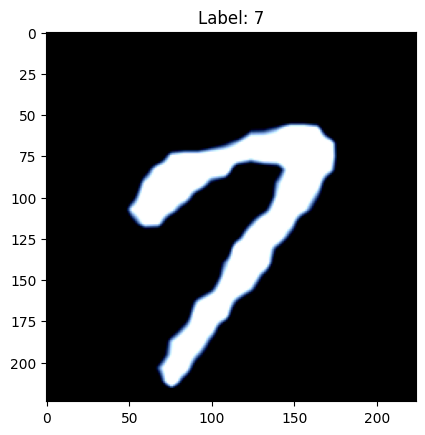

In [14]:
img, lbl = dataset[15]

# rearrange from CxHxW to HxWxC && set value between 0 and 1
img = img.permute(1, 2, 0).clamp(0,1)

plt.imshow(img)
plt.title(f"Label: {lbl}")
plt.show()

In [15]:
training_set, testing_set, validation_set = data.random_split(dataset, [0.8, 0.1, 0.1], generator)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=64, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

In [16]:
model = models.alexnet(weights=None)
model.classifier[6] = nn.Linear(4096, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #learning rate

In [17]:
num_epochs = 10

train_losses = []
test_accuracies = []

print("Starting Training!")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

print("Training Complete!")

Starting Training!


KeyboardInterrupt: 

In [10]:
model.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
        
    print(f'Accuracy of the model test images: {correct / total:.2%}')

Accuracy of the model test images: 98.73%


In [ ]:
    torch.save(model.state_dict(), "weights.pth")

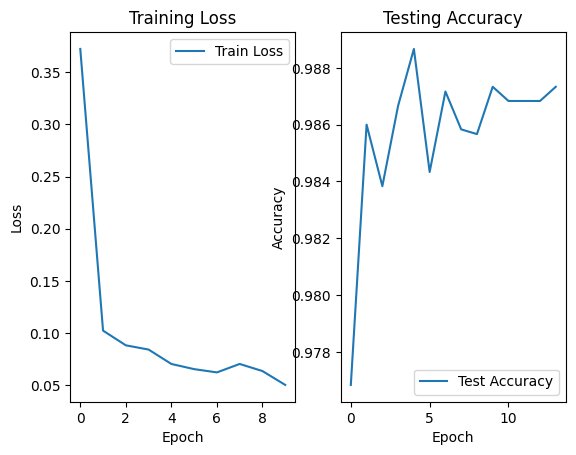

In [12]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()